# XGBoost Machine learning Model

 Data loaded successfully:
Train shape: (26882, 5000) | Test shape: (6721, 5000)

 Training XGBoost model***** : 


d:\conda_envs\spamham\lib\site-packages\xgboost\training.py:183: UserWarning: [03:23:07] WARNING: D:\bld\xgboost-split_1758007502304\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Showing Evaluation Metrics Results upto 2 decimals
 Accuracy:  98.02%
 Precision: 96.98%
 Recall:    99.21%
 F1-Score:  98.08%
 ROC-AUC:   99.76%

 Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      3288
        Spam       0.97      0.99      0.98      3433

    accuracy                           0.98      6721
   macro avg       0.98      0.98      0.98      6721
weighted avg       0.98      0.98      0.98      6721



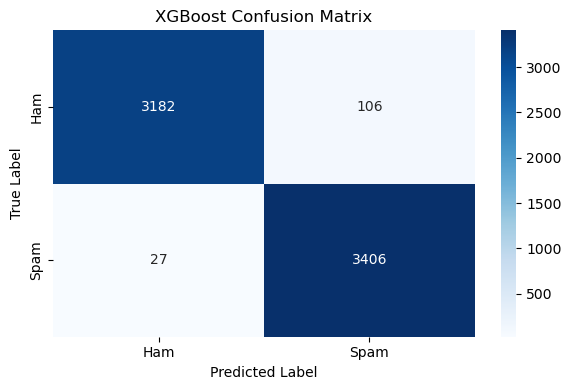

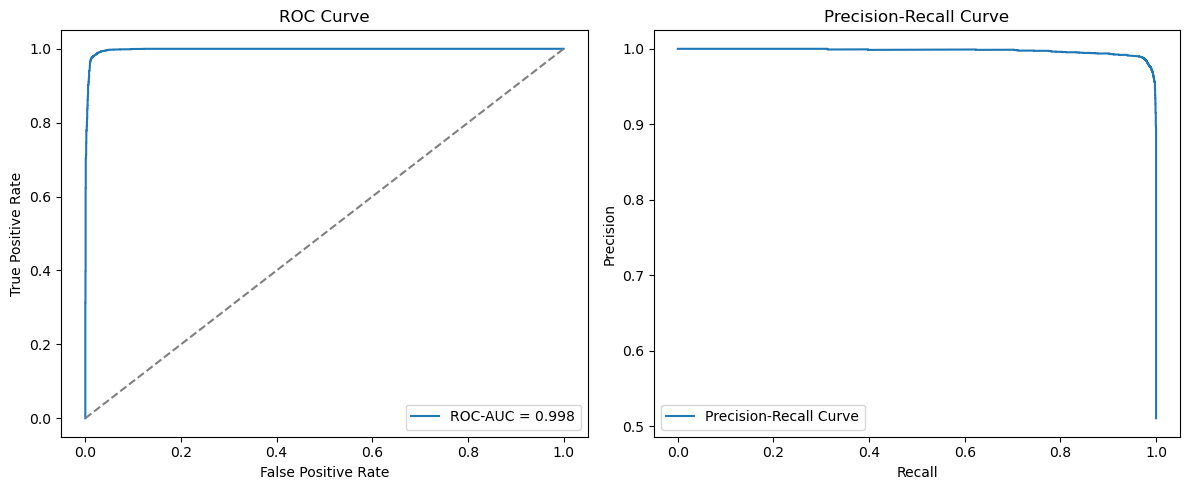


 Model training and evaluation complete! Saved as xgb_model.pkl


In [1]:
# File: xgboost.ipynb
# Training, evaluating, and saving XGBoost spam classifier results

import numpy as np
import pickle
import random
import os
from scipy.sparse import load_npz
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Reproducibility Setup
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Loading Preprocessed Data
X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf  = load_npz("X_test_tfidf.npz")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

print(" Data loaded successfully:")
print(f"Train shape: {X_train_tfidf.shape} | Test shape: {X_test_tfidf.shape}")

# Initializing hyperparametrs of model and Training XGBoost Model
xgb_model = XGBClassifier(n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=SEED,
    n_jobs=-1
)

print("\n Training XGBoost model***** : ")
xgb_model.fit(X_train_tfidf, y_train)

# Making Predictions
y_pred = xgb_model.predict(X_test_tfidf)
y_pred_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# Comprehensive Evaluation Metrics 
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n Showing Evaluation Metrics Results upto 2 decimals")
print(f" Accuracy:  {acc*100:.2f}%")
print(f" Precision: {prec*100:.2f}%")
print(f" Recall:    {rec*100:.2f}%")
print(f" F1-Score:  {f1*100:.2f}%")
print(f" ROC-AUC:   {roc_auc*100:.2f}%")
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=['Ham','Spam']))

# Confusion Matrix to see False positives and false negatives for better understanding
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve & Precision-Recall Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(12,5))

# ROC plot
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Precision-Recall
plt.subplot(1,2,2)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# Saving Model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
print("\n Model training and evaluation complete! Saved as xgb_model.pkl")


## 93 and 29 : there are still false positive and false negatives respectively in testing phase(unseen data). That is area of concern to explore, as this traditional ML is facing challenges in understanding contextual meaning, due to inputs as sparse TFID vectors

# Demonstration with GRADIO APP

In [2]:
pip install gradio


In [3]:
if __name__ == "__main__":
    import gradio as gr
    import re, string
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    import pickle

    with open("xgb_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("tfidf_vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+", "", text)
        text = re.sub(r"\d+", "", text)
        text = text.translate(str.maketrans("", "", string.punctuation))
        tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
        return " ".join(tokens)

    def predict_spam(email_text):
        clean = clean_text(email_text)
        vect = vectorizer.transform([clean])
        pred = model.predict(vect)[0]
        label = "Spam" if pred == 1 else "Ham (Safe Email)"
        return f"Prediction: {label}"

    examples = [
        ["Please open link for a meeting"],
        ["Please pay with this link to get reward of $10000"]
    ]

    demo = gr.Interface(
        fn=predict_spam,
        inputs=gr.Textbox(lines=4, label="Enter Email Text"),
        outputs="text",
        title="Spam Detection Demo",
        description="This demo uses a trained XGBoost model and TF-IDF vectorizer to classify emails as spam or safe.",
        examples=examples
    )

    demo.launch()


d:\conda_envs\spamham\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
